In [ ]:
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from tensorflow.keras import optimizers, layers, models
from matplotlib import pyplot as plt

## Data Prep

In [38]:
image_dir = "images/lattice_points"
train_files = [[], []]

for file in os.listdir(os.path.join(image_dir, "no")):
    if file.endswith(".jpg"):
        train_files[0].append(os.path.join(image_dir, "no", file))

for file in os.listdir(os.path.join(image_dir, "yes")):
    if file.endswith(".jpg"):
        train_files[1].append(os.path.join(image_dir, "yes", file))

In [39]:
all_images = []
all_labels = []

for i in range(2):
    for file in train_files[i]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]
        img = cv2.Canny(img, 0, 255)
        
        img = img.astype(np.float32) / 255.0
        
        all_images.append(img)
        
        label = [0, 0]
        label[i] = 1
        all_labels.append(label)

all_images = np.array(all_images)[..., np.newaxis]
all_labels = np.array(all_labels)

In [40]:
print(all_images.shape, all_labels.shape)
print(all_images.max())
print(all_labels[0])

(518, 21, 21, 1) (518, 2)
1.0
[1 0]


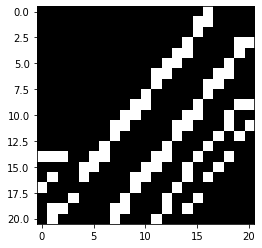

In [41]:
plt.figure()
plt.imshow(all_images[0][:, :, 0], cmap="gray")

In [42]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

train_indices = random.sample(range(len(all_images)), int(len(all_images) * 0.8))

for i in range(len(all_images)):
    if i in train_indices:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])
    else:
        valid_images.append(all_images[i])
        valid_labels.append(all_labels[i])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=4,
    height_shift_range=4)

## Initialize Network

In [ ]:
model = models.Sequential()
model.add(layers.Dense(441, input_shape=(21, 21, 1)))

for i in range(2):
    for j in [3, 2, 1]:
        model.add(layers.Conv2D(16, j, activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    
model.add(layers.Dense(128, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizers.RMSprop(lr=1e-3), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [ ]:
model.summary()

In [ ]:
def generate_data(train_images, train_labels, batch_size):
    gen = datagen.flow(train_images, train_labels, batch_size=batch_size)
    while True:
        x, y = gen.next()
        yield x, y

In [43]:
batch_size = train_images.shape[0]
epochs = 100

history = model.fit_generator(generate_data(train_images, train_labels, batch_size=batch_size),
                              steps_per_epoch=train_images.shape[0] / batch_size,
                              epochs=epochs, validation_data = (valid_images, valid_labels))

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.2136 - categorical_accuracy: 0.9203 - val_loss: 0.1934 - val_categorical_accuracy: 0.9423
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.1783 - categorical_accuracy: 0.9251 - val_loss: 0.2098 - val_categorical_accuracy: 0.9423
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.1722 - categorical_accuracy: 0.9396 - val_loss: 0.2076 - val_categorical_accuracy: 0.9519
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.1771 - categorical_accuracy: 0.9396 - val_loss: 0.2976 - val_categorical_accuracy: 0.8846
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.1976 - categorical_accuracy: 0.9251 - val_loss: 0.4123 - val_categorical_accuracy: 0.8269
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.1751 - categorical_accuracy: 0.9372 - val_loss: 0.3107 - val_categorical_accuracy: 0.8942
Epoch 7/100
1/1 [===========

Epoch 52/100
1/1 [==============================] - 1s 1s/step - loss: 0.1959 - categorical_accuracy: 0.9348 - val_loss: 0.1840 - val_categorical_accuracy: 0.9231
Epoch 53/100
1/1 [==============================] - 1s 1s/step - loss: 0.2145 - categorical_accuracy: 0.9251 - val_loss: 0.1776 - val_categorical_accuracy: 0.9231
Epoch 54/100
1/1 [==============================] - 1s 1s/step - loss: 0.1947 - categorical_accuracy: 0.9227 - val_loss: 0.2234 - val_categorical_accuracy: 0.9231
Epoch 55/100
1/1 [==============================] - 1s 1s/step - loss: 0.2022 - categorical_accuracy: 0.9300 - val_loss: 0.2678 - val_categorical_accuracy: 0.8942
Epoch 56/100
1/1 [==============================] - 1s 1s/step - loss: 0.2032 - categorical_accuracy: 0.9275 - val_loss: 0.3125 - val_categorical_accuracy: 0.8654
Epoch 57/100
1/1 [==============================] - 1s 1s/step - loss: 0.1661 - categorical_accuracy: 0.9444 - val_loss: 0.2509 - val_categorical_accuracy: 0.9038
Epoch 58/100
1/1 [====

In [44]:
model_json = model.to_json()
with open("lattice_points_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lattice_points_model.h5")